# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:

- tokenize with MWEs using spacy
- estimate LDA topic models with tomotopy
- visualize and evaluate topic models
- apply topic models to interpretation of hotel reviews

In [23]:
from collections import Counter

import numpy as np
import pandas as pd
import tomotopy as tp
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

## Prepare data

In [24]:
df = pd.read_pickle("/data/hotels_id.pkl")
mdl = tp.LDAModel.load("hotel-topics.bin")
labels = list(pd.read_csv("labels.csv")["label"])

In [25]:
df[df["overall"] == 1]["offering_id"].value_counts().head(20)

214197     1359
93421       684
223023      486
93520       329
111418      238
112066      233
99766       206
93437       195
99307       179
119728      169
93618       168
80602       157
1938661     156
122007      147
93450       145
93466       145
93464       144
101653      143
93356       139
87595       132
Name: offering_id, dtype: int64

Pick a hotel with a lot of 1 star ratings (other than # 93520) and pull out all of its reviews

In [26]:
hotel = df.query("offering_id==214197").copy()
hotel["overall"].value_counts()

1.0    1359
3.0     770
2.0     555
4.0     434
5.0     116
Name: overall, dtype: int64

In [27]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open("terms.txt"))

In [28]:
hotel["tokens"] = (hotel["title"] + " " + hotel["text"]).progress_apply(
    tokenizer.tokenize
)

  0%|          | 0/3234 [00:00<?, ?it/s]

## Apply topic model

In [29]:
hotel["doc"] = [mdl.make_doc(words=toks) for toks in hotel["tokens"]]
topic_dist, ll = mdl.infer(hotel["doc"])

## Interpret model

What topics are associated with a review?

In [30]:
hotel["text"].iloc[0]

"The front desk girl was extremely rude and wouldn't let us check into the room. We were stranded in manhattan and really needed a place to stay although since we made our reservations online she said we couldn't check in. I used to work at a hotel and was extremely confused by the rude service and not disappointed that even tho the hotel had 500 empty rooms they couldn't let us check into ours. Terrible service and I will make sure to inform my friends to never stay here and I will never return. Worst customer service ever!!"

In [31]:
hotel["doc"].iloc[0].get_topics(top_n=5)

[(27, 0.5980048179626465),
 (7, 0.13996367156505585),
 (22, 0.11773998290300369),
 (23, 0.02515696920454502),
 (12, 0.008611953817307949)]

In [32]:
mdl.get_topic_words(17)

[('san_francisco', 0.056061968207359314),
 ('union_square', 0.04574167728424072),
 ('sf', 0.029658952727913857),
 ('wharf', 0.025003427639603615),
 ('city', 0.023310508579015732),
 ('fisherman', 0.01826431043446064),
 ('right', 0.01748296245932579),
 ('around', 0.015822600573301315),
 ('walk', 0.015659820288419724),
 ('chinatown', 0.014683136716485023)]

In [33]:
mdl.get_topic_words(31)

[('wine', 0.018876856192946434),
 ('husband', 0.014850153587758541),
 ('suite', 0.013407058082520962),
 ('upgraded', 0.013220852240920067),
 ('bottle', 0.011940686963498592),
 ('evening', 0.011265690438449383),
 ('arrival', 0.011265690438449383),
 ('upon', 0.010986381210386753),
 ('anniversary', 0.010823450982570648),
 ('champagne', 0.010753624141216278)]

In [34]:
[(labels[x], y) for x, y in hotel["doc"].iloc[0].get_topics(top_n=5)]

[('TOLD', 0.5980048179626465),
 ('DIRTY', 0.13996367156505585),
 ('REVIEWS', 0.11773998290300369),
 ('NEW_YORK', 0.02515696920454502),
 ('AM', 0.008611953817307949)]

What are the most common topics?

In [35]:
hotel["topics"] = [
    [labels[t] for t in map(first, d.get_topics(3))] for d in hotel["doc"]
]

In [36]:
hotel["topics"]

40902       [TOLD, DIRTY, REVIEWS]
40903              [4, AWAY, TOLD]
40904           [HE, CHECK, DIRTY]
40921          [TOLD, AM, REVIEWS]
40922     [NEW_YORK, 4, RECOMMEND]
                    ...           
123975         [SHOWER, NIGHTS, 4]
125268            [NYC, AWAY, CAR]
125539    [PEOPLE, NEW_YORK, MADE]
126377            [DIRTY, USE, AM]
136070    [BIT, NEW_YORK, REVIEWS]
Name: topics, Length: 3234, dtype: object

In [37]:
topic_freq = Counter(concat(hotel["topics"]))
topic_freq.most_common()

[('DIRTY', 1570),
 ('AM', 877),
 ('NEW_YORK', 713),
 ('BIT', 606),
 ('PEOPLE', 585),
 ('REVIEWS', 563),
 ('4', 559),
 ('TOLD', 544),
 ('NIGHTS', 511),
 ('CHECK', 419),
 ('HE', 409),
 ('SHOWER', 367),
 ('LOBBY', 324),
 ('NYC', 249),
 ('NOISE', 208),
 ('AWAY', 129),
 ('RECOMMEND', 129),
 ('ALWAYS', 124),
 ('PARKING', 120),
 ('MADE', 119),
 ('USE', 93),
 ('GREAT_LOCATION', 86),
 ('BEST', 79),
 ('VIEW', 62),
 ('HUSBAND', 60),
 ('CAR', 40),
 ('BUSINESS', 30),
 ('FOOD', 29),
 ('AREA', 26),
 ('SUITE', 22),
 ('COFFEE', 20),
 ('POOL', 15),
 ('WINE', 9),
 ('SAN_FRANCISCO', 6)]

Most common topics in 1 star reviews?

In [38]:
topic_freq = Counter(concat(hotel.query("overall==1")["topics"]))
topic_freq.most_common()

[('DIRTY', 1099),
 ('AM', 424),
 ('TOLD', 339),
 ('HE', 259),
 ('PEOPLE', 231),
 ('4', 229),
 ('CHECK', 184),
 ('LOBBY', 160),
 ('SHOWER', 159),
 ('BIT', 148),
 ('NIGHTS', 124),
 ('REVIEWS', 111),
 ('NEW_YORK', 105),
 ('NOISE', 79),
 ('PARKING', 57),
 ('ALWAYS', 56),
 ('MADE', 49),
 ('BEST', 35),
 ('USE', 32),
 ('AWAY', 31),
 ('RECOMMEND', 31),
 ('NYC', 28),
 ('HUSBAND', 25),
 ('CAR', 16),
 ('BUSINESS', 11),
 ('AREA', 9),
 ('VIEW', 8),
 ('SUITE', 7),
 ('GREAT_LOCATION', 7),
 ('FOOD', 7),
 ('POOL', 6),
 ('WINE', 5),
 ('COFFEE', 4),
 ('SAN_FRANCISCO', 2)]

Most common topics in 5 star reviews?

In [39]:
topic_freq = Counter(concat(hotel.query("overall==5")["topics"]))
topic_freq.most_common()

[('REVIEWS', 44),
 ('NEW_YORK', 44),
 ('AM', 29),
 ('NIGHTS', 27),
 ('NYC', 23),
 ('PEOPLE', 21),
 ('4', 16),
 ('RECOMMEND', 15),
 ('BIT', 13),
 ('CHECK', 11),
 ('SHOWER', 10),
 ('LOBBY', 9),
 ('HE', 9),
 ('BEST', 8),
 ('HUSBAND', 8),
 ('AWAY', 7),
 ('GREAT_LOCATION', 7),
 ('ALWAYS', 7),
 ('DIRTY', 7),
 ('VIEW', 7),
 ('TOLD', 6),
 ('MADE', 5),
 ('NOISE', 4),
 ('PARKING', 2),
 ('COFFEE', 2),
 ('SUITE', 2),
 ('POOL', 1),
 ('BUSINESS', 1),
 ('FOOD', 1),
 ('USE', 1),
 ('AREA', 1)]

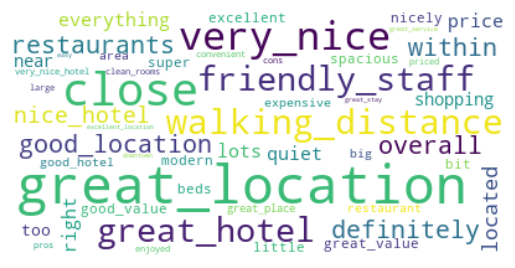

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topic_id = 28
topic_words = mdl.get_topic_words(topic_id, top_n=50)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(topic_words))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

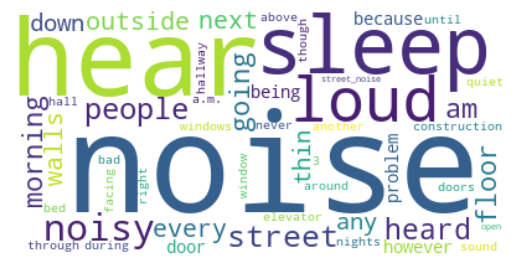

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topic_id = 2
topic_words = mdl.get_topic_words(topic_id, top_n=50)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(topic_words))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

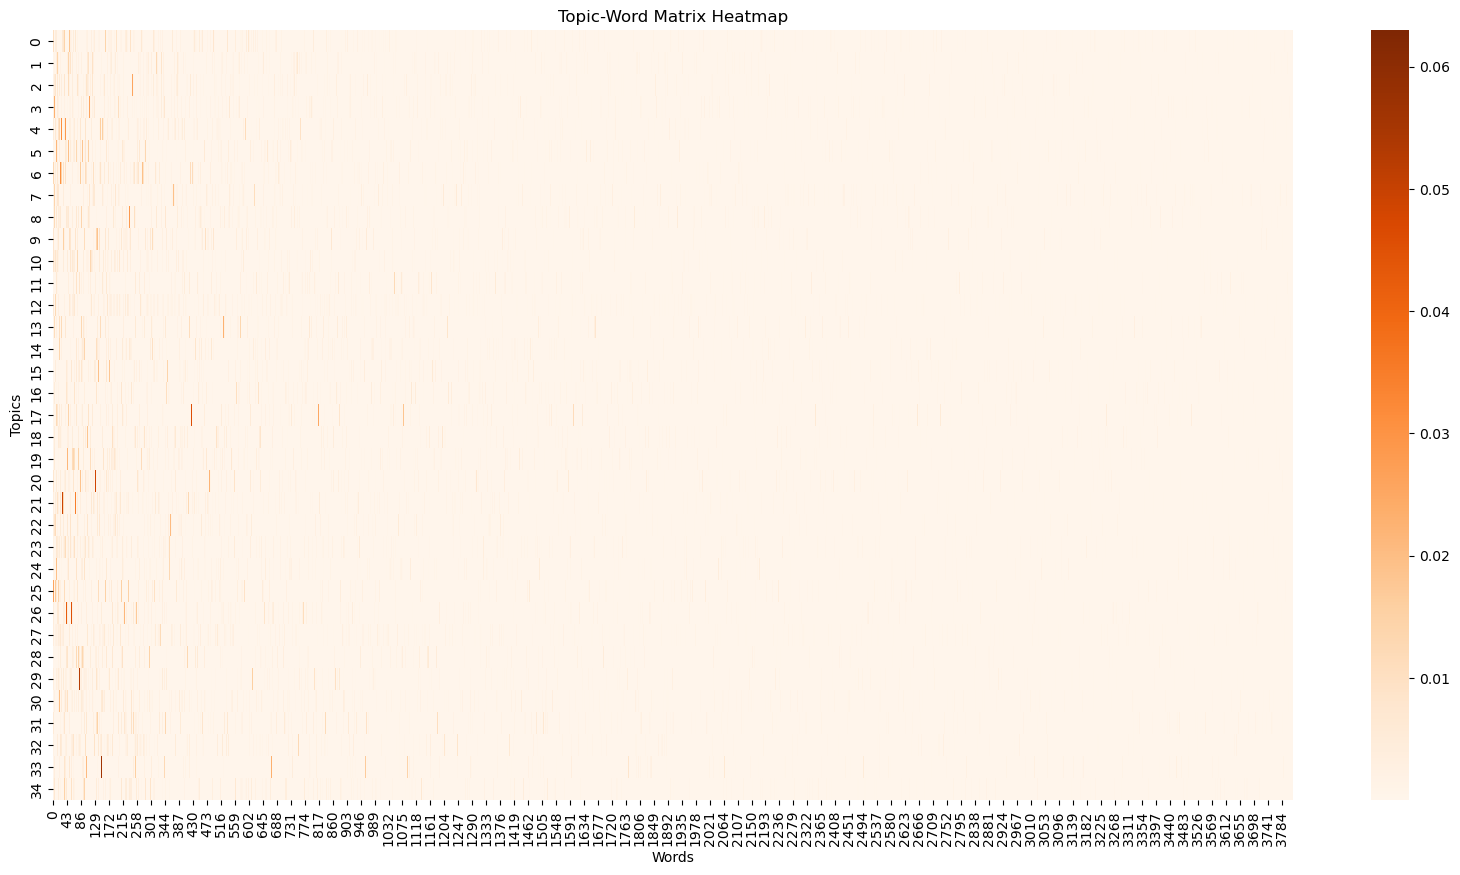

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# extract the topic-word matrix from the model
num_topics = mdl.k 
num_words = len(mdl.get_topic_word_dist(topic_id=0))
topic_word_matrix = np.zeros((num_topics, num_words))

for i in range(num_topics):
    for j in range(num_words):
        topic_word_matrix[i,j] = mdl.get_topic_word_dist(topic_id=i)[j]

# create a pandas dataframe from the matrix
df_topic_words = pd.DataFrame(topic_word_matrix)

# create the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df_topic_words, cmap='Oranges')
plt.title('Topic-Word Matrix Heatmap')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()


## Report

Finish this notebook by writing a brief report to the hotel managers describing what you've found in the reviews of their hotel, along with some actionable advice. Use whatever data, charts, word clouds, etc. that you think will help you make your case.

The above code mainly shows how to tokenize hotel reviews using spacy, estimate LDA topic models with tomotopy and visualize and evaluate topic models. Here I have taken sample data of 50k hotel reviews. I have chosen a 35 topic LDA model which is estimated using tomotopy.Also we have plotted a scatter plot in which each circle represents the proportion of number of words present in each topic.The scatter plot generated spreads out the topics in space without too much overlap.

Some important findings that I found after analyzing the customer reviews is that 85% of reviews are positive and the remaining were negative. The most common compliments are about the location, cleanliness and friendly staff. Customers also mentioned about easy access to local attractions and they appreciated the staff for being so helpful and friendly.
One common complaint is about the slow Wi-Fi speed which needs to be improved.

To get more information about the reviews, I have created one positive wordcloud and one negative word cloud. The most commonly used positive words are great location, friendly staff and walkable for many attractions. On the other hand the negative words conclude that noise from neighbouring rooms or the street can be a disturbance.

Based on my findings, my recommendations to improve customer satisfaction is by improving the wifi speed and this will definitely result in more positive reviews . Many guests quoted issues with noise levels which can be improved my soundproofing or some other measures.